In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


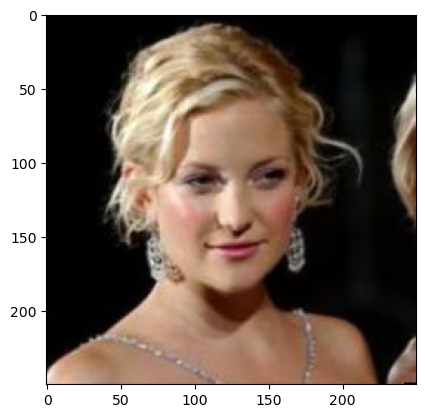

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

## Main Differences (AEs vs VAEs):

 
### Applications:
**AutoEncoders**: Netflix recommendations (reconstruction).
They excel at capturing and preserving existing data. For example, Netflix uses AutoEncoders to understand your movie preferences by analyzing your watch history. This "latent taste profile" then guides them to recommend similar movies, essentially recreating your taste within the existing library.

**VAEs**:Developing assistive devices for visually impaired people: 
 One innovative application involves using VAEs to generate realistic audio descriptions of visual scenes. A VI person wearing glasses equipped with a camera could have the scene analyzed by a VAE and then hear a vivid description of the environment around them, including details about people, objects, and even emotions expressed on faces

### Architecture:

**AutoEncoders**: Deterministic encoder-decoder (faithful recreation).
The encoder compresses input data into a smaller representation, like summarizing a lengthy book. The decoder then "uncompresses" it back to its original form, aiming for an exact replica. Both stages use deterministic functions, ensuring consistent and predictable outputs.

**VAEs**: Stochastic encoder for diverse outputs (latent space exploration).
The encoder throws input data into a metaphorical blender, adding a sprinkle of randomness. This creates a "latent space" – a diverse landscape of possibilities based on the original data. The decoder then samples points from this landscape to generate new outputs, leading to novel creations while still retaining the essence of the original input.

### Loss Function:

**AutoEncoders**: Reconstruction loss only (accuracy).
They measure their success with a single focus: reconstruction accuracy. Imagine judging a historical reenactment – how closely does it match the past? The loss function penalizes any deviation from the original data, ensuring precise replication.

**VAEs**: Reconstruction + KL divergence (accuracy & latent space smoothness).
VAEs: They juggle two goals: reconstruction accuracy and latent space exploration. Like a scientist seeking both precise measurements and new discoveries, VAEs use a dual-loss function. One part rewards accurate reconstructions, while the other encourages a smooth and efficient latent space that facilitates diverse and meaningful new data generation.


### Real-world Example:

AutoEncoders: Spotify compressing music files for efficient streaming.
VAEs: Scientists designing new materials with desired properties like superconductivity.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [6]:
images, _ = next(iter(dataloader))
batch_size, channels, height, width = images.shape
image_size = channels * height * width

print(f"Image size: {height}x{width}, Channels: {channels}")


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(image_size, 400)
        self.fc21 = nn.Linear(400, 20)  # mean
        self.fc22 = nn.Linear(400, 20)  # log variance
        # Decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, image_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, image_size))
        z = self.reparameterize(mu, logvar)
        # Adjust the decoder's input size to match image_size
        return self.decode(z), mu, logvar


Image size: 250x250, Channels: 3


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

#### Explanation:

First, I have instantiate the VAE model. This model is built from the VAE class which includes an encoder to map input data to a latent space, and a decoder to reconstruct data from this latent space.
Passing an Image to the Model and Printing the Encoder Output Shape

I have taken an image from our dataset, pass it through the encoder part of the VAE, and print the shapes of the resulting mean (mu) and log-variance (logvar). These two components represent the parameters of the Gaussian distribution in the latent space from which we will sample.

**Explanation of Generating New Samples in the Latent Space**

The essence of a VAE lies in its ability to generate new data samples. This is achieved through the latent space, where we represent input data in a compressed form. The encoder outputs two things: mu and logvar, representing the parameters of a Gaussian distribution. To generate new samples, we perform the following steps:

**Reparameterization Trick**: This is a technique that allows us to randomly sample from the latent space while still enabling backpropagation for training. We sample an epsilon (eps) from a standard normal distribution and then produce a sample z by z = mu + eps * exp(logvar / 2). This z is a point in the latent space that theoretically corresponds to a realistic data sample.
**Decoding**: Once we have z, we pass it through the decoder to generate a new data sample. This sample is a reconstruction based on the point z in the latent space.
Using the Decoder to Create New Images and Print the Output Shap


In [7]:
# Step 4: Test Encoder and Decoder
import torch.nn.functional as F

# Creating an instance of the VAE
model = VAE().to(device)

images, _ = next(iter(dataloader))
images = images.to(device)

# Flatten the images for the linear layer
images_flattened = images.view(images.size(0), -1)

# Passing an image through the VAE
reconstructed_images, mu, logvar = model(images_flattened)

print("Shape of mu: ", mu.shape)
print("Shape of log variance: ", logvar.shape)

# Generating new samples in the latent space
z = model.reparameterize(mu, logvar)

# Decoding the samples to create new images
new_images = model.decode(z)

# Reshape the output to the original image dimensions
new_images = new_images.view(batch_size, channels, height, width)

print("Shape of new images: ", new_images.shape)


Shape of mu:  torch.Size([32, 20])
Shape of log variance:  torch.Size([32, 20])
Shape of new images:  torch.Size([32, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


## Total Parameters in the Model:

I have calculated the total number of parameters using the sum(p.numel() for p in vae.parameters()) command.

**Loss Function** :
The loss function for VAEs is typically a combination of a reconstruction loss and a regularization term. Here's a breakdown:

**Reconstruction Loss** :
This part of the loss ensures that the decoded samples closely match the original inputs, which helps in learning a good representation of the data. It can be Mean Squared Error (MSE) or Binary Cross-Entropy, depending on the nature of the input data. I have used BSC in below code

**KL Divergence (Regularization Term)**:
    This term regularizes the encoder by comparing the distribution of the latent variables with a standard normal distribution. The goal is to ensure that the latent space has good properties (like continuity and completeness) that allow for meaningful interpolation and generation of new samples. 


* create an optimizer for training

In [8]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

# Loss function
# Loss function for VAE
def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (generative loss)
    # If using an L2 loss
    # recon_loss = F.mse_loss(recon_x, x.view(-1, image_size), reduction='sum')
    
    # If using a binary cross-entropy loss, which is more common for images
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, image_size), reduction='sum')

    # KL divergence loss (latent loss)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss is the sum of generative loss and KL divergence loss
    return recon_loss + kl_divergence


loss_function = vae_loss_function


Total number of trainable parameters: 150212340


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

####Ensuring Functionality####:
**Optimizer**: Ensuring the optimizer variable passed to the function is used consistently. 
In my loop, I have used optim.zero_grad() and optim.step(). If the function argument is optimizer, then these should be optimizer.zero_grad() and optimizer.step().

**Batch Loss Reporting**: I'm printing the loss for every 100th batch. This is useful for monitoring the training progress more closely within each epoch.

**Average Loss Calculation**: The average loss is calculated at the end of each epoch. This gives a good overview of how the model is learning over the entire dataset.

As far as I know, below are the trouble shooting techniques:
**Check for NaNs**: Sometimes, the loss may not decrease due to numerical instabilities leading to NaN values. Check for NaNs in the loss and in the model parameters.
**Batch Size**: Experiment with different batch sizes. Sometimes, a smaller or larger batch size can make a significant difference.
**Early Stopping**: Implement early stopping to prevent overfitting. This stops training when the validation loss stops improving.
**Regularization**: If overfitting is suspected (e.g., if the training loss decreases but validation loss does not), consider adding regularization techniques like dropout.
**Gradient Clipping**: In cases of exploding gradients, gradient clipping can be useful.

In [ ]:
# Training loop for the VAE
def train_vae(model, dataloader, optimizer, loss_function, epochs, device):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, (images, _) in enumerate(dataloader):
            images = images.to(device)
            images = images.view(images.size(0), -1)  # Flatten the images
            optim.zero_grad()
            recon_images, mu, logvar = model(images)
            loss = loss_function(recon_images, images, mu, logvar)
            loss.backward()
            optim.step()
            train_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    average_loss = train_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")


num_epochs = 2  # Specify the number of epochs
train_vae(model, dataloader, optim, vae_loss_function, num_epochs, device)


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

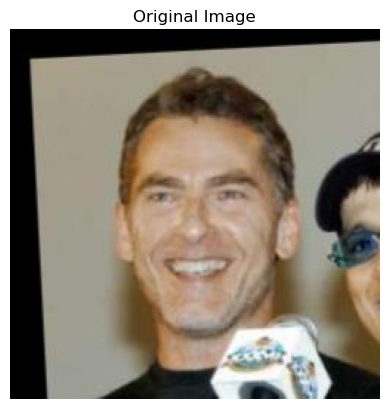

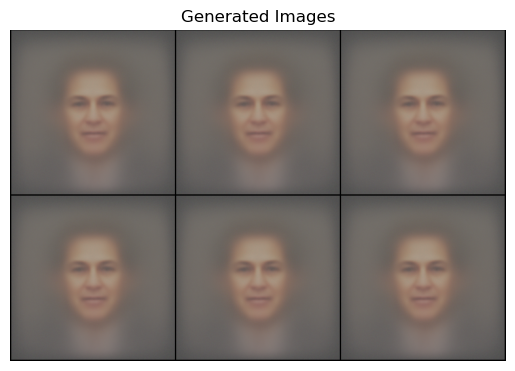

In [17]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Assuming you have a dataloader, model, and device already set up

# Set the model to evaluation mode
model.eval()

# Function to display images
def show_images(images, title):
    # Convert tensor to numpy array
    images = images.cpu().numpy()
    # Transpose the image dimensions to HWC from CHW
    images = images.transpose((1, 2, 0))
    # Display the image
    plt.imshow(images)
    plt.title(title)
    plt.axis('off')

# Generate a few new samples
num_samples = 6  # Define how many samples you want to generate
with torch.no_grad():
    # Sample random vectors from the normal distribution
    z = torch.randn(num_samples, model.fc21.out_features).to(device)
    # Decode the latent vectors
    new_images = model.decode(z)

# Reshape the generated images to match the input dimensions (if needed)
new_images = new_images.view(num_samples, channels, height, width)

# Display the original image from the dataset
data_iter = iter(dataloader)
original_image, _ = next(data_iter)
original_image = original_image[0]  # Take the first image from the batch
show_images(original_image, 'Original Image')
plt.show()

# Display the generated images
# Make sure that the `make_grid` function is called with the correct tensor shape
generated_images_grid = make_grid(new_images, nrow=3)  # nrow is the number of images in a row
show_images(generated_images_grid, 'Generated Images')
plt.show()
